In [ ]:
# Paper : "Deep Unsupervised Learning using Nonequilibrium Thermodynamics" by Jascha Sohi-Dickstein et al. (2015)
# The code below was written with reference to the paper's official open source code.
# Github Repository : https://github.com/Sohl-Dickstein/Diffusion-Probabilistic-Models

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np

In [ ]:
class MultiscaleConvolution(nn.Module):
    """
    Define Multi Scale Convolution layers used in MLP.

    1. Perform mean pooling to downsample the image to multiple scales. Downsampling is performed in powers of two.
    2. Performing convolution at each scale.
    3. Upsample all scales to full resolution, and sum the resulting images.
    4. Perform a pointwise nonlinear transformation, consisting of a soft relu.

    Refer to Appendix D of the paper for more detailed.

    Parameters:
        num_channels (int): Number of input channels.
        num_filters (int): Number of output channels.
        num_scales (int): Number of scales.
        filter_size (int): Size of the convolutional filter.

    Example:
        >>> msc = MultiscaleConvolution(num_channels=3, num_filters=64, num_scales=3, filter_size=3)
        >>> x = torch.randn(1, 3, 224, 224)
        >>> y = msc(x)
        >>> print(y.shape) # torch.Size([1, 64, 224, 224])
    """
    def __init__(self, num_channels, num_filters, num_scales=2, filter_size=3):
        super(MultiscaleConvolution, self).__init__()
        self.num_scales = num_scales
        self.filter_size = filter_size
        self.num_filters = num_filters
        self.conv_layers = nn.ModuleList()
        for scale in range(self.num_scales):
            conv_layer = nn.Conv2d(num_channels, num_filters, kernel_size=filter_size, padding=filter_size//2)
            self.conv_layers.append(conv_layer)

    def activation_fn(self,x):
        return torch.nn.functional.softplus(x)

    def downsample(self,x,scale):
        return nn.functional.avg_pool2d(x, kernel_size=2**scale, stride=2**scale)

    def upsample(self,x,scale):
        return nn.functional.interpolate(x, scale_factor=2**scale, mode='bilinear', align_corners=False)

    def forward(self, x):
        output = torch.zeros(x.size(0), self.num_filters, x.size(2), x.size(3)).to(x.device)
        for scale in range(self.num_scales):
            y = self.downsample(x, scale)
            y = self.conv_layers[scale](y)
            y = self.activation_fn(y)
            y = self.upsample(y, scale)
            output += y
        return output / self.num_scales

# Define the MLP for estimating mean and variance
class MLP(nn.Module):
    """
    MLP for estimating mean and variance. Structure of the model is depicted in the figure below.

    Parameters:
        num_channels (int): Number of input channels.
        num_layers (int): Number of layers in the MLP.
        num_output_channels (int): Number of output channels.

    Example:
        >>> mlp = MLP(num_channels=3, num_layers=100, num_output_channels=64)
        >>> x = torch.randn(1, 3, 224, 224)
        >>> y = mlp(x)
        >>> print(y.shape) # torch.Size([1, 64, 224, 224])
    """
    def __init__(self,num_channels=1,num_layers=100,num_output_channels=20):
        super(MLP, self).__init__()
        self.num_channels = num_channels
        self.num_layers = num_layers
        self.num_output_channels = num_output_channels
        self.msc = nn.ModuleList()
        self.dense = nn.ModuleList()
        self.conv = nn.ModuleList()
        for i in range(num_layers):
            self.msc.append(MultiscaleConvolution(num_channels, num_channels))
            self.dense.append(nn.Conv2d(num_channels,num_channels,1,1))
            self.dense.append(nn.Tanh())
            if i==0:
                self.conv.append(nn.Conv2d(num_channels, num_output_channels, kernel_size=1, stride=1))
            else:
                self.conv.append(nn.Conv2d(num_output_channels, num_output_channels, kernel_size=1, stride=1))
            self.conv.append(nn.Tanh())

    def forward(self, x):
        x0,x1 = x.clone(),x.clone()
        for i in range(self.num_layers):
            x0 = self.msc[i](x0)
            x1 = self.dense[i](x1)
        if x0.isnan().any():
            print('x0 emergency')
        if x1.isnan().any():
            print('x1 emergency')
        y = x0 + x1
        for i in range(self.num_layers):
            y = self.conv[i](y)
        return y

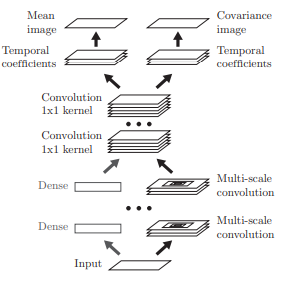

In [ ]:
class DiffusionModel(nn.Module):
    """
    Diffusion model for forward process and training.

    There are 7 fucntions in this class.
    - forward_process : Carries out forward process and generate mu_pos and sigma_pos for q(x^(t-1)|x^(t),x^(0))
    - get_mu_sigma : Generate mu and sigma for p(x^(t-1)|x^(t))
    > 3 functions (generate_temporal_basis, get_t_weights, temporal_readout) are used in get_mu_sigma
    - get_negL_bound : Compute the lower bound on the log likelihood
    - cost_single_t : Output final value K using forward_process, get_mu_sigma, and get_negL_bound

    Parameters:
        spatial_width (int) : Spatial width of training data
        n_colors (int) : The number of color channels in training data
        n_temporal_basis (int) : The number of temporal basis functions to capture time-step dependence of model
        trajectory_length (int) : The number of time steps in the trajectory
        beta_start (float) : The value of beta at the start of the trajectory
        beta_end (float) : The value of beta at the end of the trajectory
        hidden_dim (int) : The dimension of the hidden layer in the MLP

    Example:
        >>> model = DiffusionModel(spatial_width=28, n_colors=1, n_temporal_basis=10, trajectory_length=1000)
        >>> x = torch.randn(1, 1, 28, 28)
        >>> loss = -model.cost_single_t(x)
    """
    def __init__(self, spatial_width, n_colors, n_temporal_basis=10, trajectory_length=1000, beta_start=0.0001, beta_end=0.002, hidden_dim=256):
        super(DiffusionModel, self).__init__()
        self.spatial_width = spatial_width
        self.n_colors = n_colors
        self.n_temporal_basis = n_temporal_basis
        self.trajectory_length = trajectory_length

        # Generate temporal_basis to be used in function temporal_readout
        self.temporal_basis = self.generate_temporal_basis(trajectory_length, n_temporal_basis)

        # Linearly spaced betas for forward diffusion
        self.beta = torch.linspace(beta_start, beta_end, trajectory_length).to(torch.float32).to(device)
        self.alpha = (1.0 - self.beta).to(device)
        self.alpha_cum = torch.cumprod(self.alpha.to(torch.float32), dim=0).to(device)

        # MLP for estimating mean (mu) and variance (sigma)
        self.mlp = MLP(n_colors, 100, 2*n_colors*n_temporal_basis)

    def forward_process(self, x):
        """
        Forward diffusion process.
        Mu and sigma here implies mean and variance of the conditional probability distribution q(x^(t-1)|x^(t),x^(0))

        Parameters:
            x (torch.Tensor): Input data of shape (batch_size, n_colors, spatial_width, spatial_width)

        Returns:
            noisy_x (torch.Tensor): Noisy input data of shape (batch_size, n_colors, spatial_width, spatial_width)
            t (torch.Tensor): Randomly sampled time step of shape (1,)
            mu (torch.Tensor): Mean of the forward diffusion process of shape (batch_size, n_colors, spatial_width, spatial_width)
            sigma (torch.Tensor): Variance of the forward diffusion process of shape (batch_size, 1, 1, 1)
        """
        noise = torch.randn_like(x)
        t = torch.randint(10, self.trajectory_length, (1,)).to(device)
        alpha_cum_t = self.alpha_cum[t].view(1, 1, 1, 1)
        noisy_x = torch.sqrt(alpha_cum_t) * x + torch.sqrt(1 - alpha_cum_t) * noise

        alpha_t = self.alpha[t].view(1,1,1,1)
        beta_t = self.beta[t].view(1,1,1,1)
        mu1_sc1 = torch.sqrt(alpha_cum_t / alpha_t)
        mu2_sc2 = torch.sqrt(1 / alpha_t)
        cov1 = 1 - alpha_cum_t/alpha_t
        cov2 = beta_t / alpha_t
        lam = 1/cov1 + 1/cov2

        mu = (x * mu1_sc1 / cov1 + noisy_x * mu2_sc2 / cov2) / lam
        sigma = torch.sqrt(1/lam).view(1,1,1,1)

        return noisy_x, t, mu, sigma

    def generate_temporal_basis(self,trajectory_length, n_basis):
        """
        Generate the bump basis functions for temporal readout of mu and sigma.

        Parameters:
            trajectory_length (int): Number of timesteps in the trajectory.
            n_basis (int): Number of temporal basis functions.

        Returns:
            torch.Tensor: Temporal basis functions of shape (n_basis, trajectory_length).
        """
        # Initialize the temporal basis matrix
        temporal_basis = np.zeros((trajectory_length, n_basis))

        # Generate x values for trajectory and centers for the basis functions
        xx = np.linspace(-1, 1, trajectory_length)
        x_centers = np.linspace(-1, 1, n_basis)
        width = (x_centers[1] - x_centers[0]) / 2.0

        # Fill the temporal basis matrix
        for ii in range(n_basis):
            temporal_basis[:, ii] = np.exp(-(xx - x_centers[ii])**2 / (2 * width**2))

        # Normalize the basis functions
        temporal_basis /= np.sum(temporal_basis, axis=1, keepdims=True)

        # Convert to PyTorch tensor
        temporal_basis_tensor = torch.tensor(temporal_basis.T, dtype=torch.float32).to(device)

        return temporal_basis_tensor

    def get_t_weights(self, t):
        """Calculate temporal weights for a given time step."""
        t_weights = torch.zeros(self.trajectory_length, device=device)
        t_weights[t] = 1.0
        return t_weights.unsqueeze(-1)  # Shape: (trajectory_length, 1)

    def temporal_readout(self, Z, t):
        """Extract mu and beta coefficients from MLP output."""
        n_images = Z.shape[0]
        t_weights = self.get_t_weights(t)  # Shape: (trajectory_length, 1)

        # Reshape MLP output
        Z = Z.view(n_images, self.spatial_width, self.spatial_width, self.n_colors, 2, self.n_temporal_basis)  # Shape: (n_images, spatial_w, spatial_w, n_colors, 2, n_temp_basis)

        # Time-weighted coefficients
        coeff_weights = torch.matmul(self.temporal_basis, t_weights)  # Shape: (n_temporal_basis, 1)
        concat_coeffs = torch.tensordot(Z, coeff_weights.squeeze(), dims=([5], [0]))  # Combine temporal dimensions

        # Extract mu and beta coefficients
        mu_coeff = concat_coeffs[..., 0].permute(0, 3, 1, 2)  # Shape: (n_images, n_colors, spatial_w, spatial_w)
        beta_coeff = concat_coeffs[..., 1].permute(0, 3, 1, 2)  # Shape: (n_images, n_colors, spatial_w, spatial_w)
        return mu_coeff, beta_coeff

    def get_mu_sigma(self, X_noisy, t):
        """
        Generate mu and sigma for the reverse trajectory.
        Mu and sigma here implies mean and variance of the conditional probability distribution p(x^(t-1)|x^(t))
        """
        # if X_noisy.isnan().any():
        #     print(f'{t} X_noisy emergency')
        # Apply MLP
        Z = self.mlp(X_noisy)  # Shape: (n_images, flattened_dim)
        # if Z.isnan().any():
        #     print(f'{t} Z emergency')

        # Get temporal readout
        mu_coeff, beta_coeff = self.temporal_readout(Z, t)

        # Forward variance
        beta_forward = self.beta[t]
        alpha_forward = 1. - beta_forward

        # Scale beta_coeff
        beta_coeff_scaled = beta_coeff / torch.sqrt(torch.tensor(self.trajectory_length, dtype=torch.float32)).to(X_noisy.device)
        beta_reverse = torch.sigmoid(beta_coeff_scaled + torch.log(beta_forward / (1 - beta_forward)))

        # Calculate mu and sigma
        mu = X_noisy * torch.sqrt(1. - beta_forward) + mu_coeff * torch.sqrt(beta_forward)
        sigma = torch.sqrt(beta_reverse)

        return mu, sigma

    def get_negL_bound(self, mu, sigma, mu_posterior, sigma_posterior):
        """
        Compute the lower bound on the log likelihood, as a function of mu and
        sigma from the reverse diffusion process, and the posterior mu and
        sigma from the forward diffusion process.

        Returns the difference between this bound and the log likelihood
        under a unit norm isotropic Gaussian.
        """
        # KL divergence between model transition and posterior
        KL = (
            torch.log(sigma) - torch.log(sigma_posterior)
            + (sigma_posterior**2 + (mu_posterior - mu) ** 2) / (2 * sigma**2)
            - 0.5
        )

        # Conditional entropies
        log_2_pi = np.log(2 * np.pi)
        H_startpoint = 0.5 * (1 + log_2_pi) + 0.5 * torch.log(self.beta[0])
        H_endpoint = (
            0.5 * (1 + log_2_pi)
            + 0.5 * torch.log(1-self.alpha_cum[-1])
        )
        H_prior = 0.5 * (1 + log_2_pi) + 0.5 * torch.log(torch.tensor(1.0))

        # Compute negative log likelihood bound
        negL_bound = KL.sum(dim=0) * self.trajectory_length + H_startpoint - H_endpoint + H_prior

        # Compare with isotropic Gaussian model
        negL_gauss = 0.5 * (1 + log_2_pi) + 0.5 * torch.log(torch.tensor(1.0))
        negL_diff = negL_bound - negL_gauss
        L_diff_bits = negL_diff / torch.log(torch.tensor(2.0))
        L_diff_bits_avg = L_diff_bits.mean() * self.n_colors

        return L_diff_bits_avg

    def cost_single_t(self, X_noiseless):
        """
        Compute the lower bound on the log likelihood, given a training minibatch, for a single
        randomly chosen timestep.
        Note that mu_posterior and sigma_posterior are generated by forward process, and mu and sigma
        are generated by reverse process.
        """
        X_noisy, t, mu_posterior, sigma_posterior = self.forward_process(X_noiseless)
        mu, sigma = self.get_mu_sigma(X_noisy, t)
        negL_bound = self.get_negL_bound(mu, sigma, mu_posterior, sigma_posterior)
        return negL_bound

In [ ]:
# Training function
def train(model, train_loader, optimizer, epochs, device):
    model.train()

    for epoch in range(epochs):
        total_loss = 0.0
        for x in train_loader:
            x = x.to(device)

            # Instead of maximizing log_likelihood, minimize -log_likelihood
            loss = -model.cost_single_t(x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Define training dataset loader
class CustomDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, _ = self.dataset[idx]
        return x

In [ ]:
# Main script
if __name__ == "__main__":
    # Parameters
    batch_size = 128
    learning_rate = 1e-4
    epochs = 10
    spatial_width = 28
    n_colors = 1
    n_temporal_basis = 10
    trajectory_length = 1000

    # Prepare dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    train_loader = DataLoader(CustomDataset(train_dataset), batch_size=batch_size, shuffle=True)

    # Initialize model, optimizer, and device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = DiffusionModel(spatial_width, n_colors, n_temporal_basis, trajectory_length).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train model
    train(model, train_loader, optimizer, epochs, device)

    # Save the model
    model_path = "diffusion_model.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

In [ ]:
import matplotlib.pyplot as plt

def diffusion_step(Xmid, t, get_mu_sigma, denoise_sigma, mask, XT, device):
    """
    Run a single reverse diffusion step.

    Parameters:
        Xmid (torch.Tensor) : Updated data of previous Xmid in t-1
        t (int) : Current time step
        get_mu_sigma (function) : Fucntion to calculate mu and sigma of the reverse process.
        denoise_sigma (float) : The value of sigma for denoising.
        mask (torch.Tensor) : Mask used for inpainting.
        XT (torch.Tensor) : The image data generated by forward process. The first image data to go through the reverse process.
        device (torch.device) : The device where the tensors are stored.

    Returns:
        Xmid (torch.Tensor) : The updated value of Xmid.
    """
    mu, sigma = get_mu_sigma(Xmid, t)
    if denoise_sigma is not None:
        sigma_new = (sigma**-2 + denoise_sigma**-2)**-0.5
        mu_new = mu * sigma_new**2 * sigma**-2 + XT * sigma_new**2 * denoise_sigma**-2
        sigma = sigma_new
        mu = mu_new
    if mask is not None:
        mu.flat[mask] = XT.flat[mask]
        sigma.flat[mask] = 0.
    Xmid = mu + sigma*(torch.normal(0,1,size=Xmid.shape).to(device))

    return Xmid

def generate_inpaint_mask(n_samples, n_colors, spatial_width):
    """
    The mask will be True where we keep the true image, and False where we're
    inpainting.
    """
    mask = np.zeros((n_samples, n_colors, spatial_width, spatial_width), dtype=bool)
    # simple mask -- just mask out half the image
    mask[:,:,:,spatial_width/2:] = True
    return mask.ravel()

def plot_images(images, title=None, ncols=6):
    # Helper function to plot images with a title and save them if needed.
    images = images.detach().cpu().numpy()
    n_images = images.shape[0]
    nrows = (n_images + ncols - 1) // ncols  # Calculate required rows
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
    axes = axes.flatten()

    for i in range(len(axes)):
        if i < n_images:
            img = images[i]
            if img.shape[0] == 1:  # Grayscale image
                img = img[0]
            elif img.shape[0] == 3:  # RGB image
                img = img.transpose(1, 2, 0)
            axes[i].imshow(img, cmap='gray' if img.ndim == 2 else None)
        axes[i].axis('off')

    # Hide any remaining axes
    for ax in axes[len(images):]:
        ax.axis('off')

    if title:
        fig.suptitle(title, fontsize=16)

    plt.tight_layout()
    plt.show()
    plt.close(fig)

def generate_samples(model, get_mu_sigma, device,
            n_samples=36, inpaint=False, denoise_sigma=None, X_true=None,
            base_fname_part1="samples", base_fname_part2='',
            num_intermediate_plots=4, seed=12345):
    """
    Run the reverse diffusion process. Generates image data and plots them.
    Use the trained model to generate the image data.
    """
    model.eval()
    # use the same noise in the samples every time, so they're easier to
    # compare across learning
    spatial_width = model.spatial_width
    n_colors = model.n_colors

    # set the initial state X^T of the reverse trajectory
    XT = torch.normal(0,1,size=(n_samples,n_colors,spatial_width,spatial_width)).to(device)
    if denoise_sigma is not None:
        XT = X_true + XT*denoise_sigma
        base_fname_part1 += '_denoise%g'%denoise_sigma
    if inpaint:
        mask = generate_inpaint_mask(n_samples, n_colors, spatial_width)
        XT.flat[mask] = X_true.flat[mask]
        base_fname_part1 += '_inpaint'
    else:
        mask = None

    if X_true is not None:
        plot_images(X_true, base_fname_part1 + '_true' + base_fname_part2)
    plot_images(XT, base_fname_part1 + f'_t{model.trajectory_length:04d}' + base_fname_part2)

    Xmid = XT.clone()
    for t in range(model.trajectory_length-1, 0, -1):
        Xmid = diffusion_step(Xmid, t, get_mu_sigma, denoise_sigma, mask, XT, device)
        if np.mod(model.trajectory_length-t,
            int(np.ceil(model.trajectory_length/(num_intermediate_plots+2.)))) == 0:
            plot_images(Xmid, base_fname_part1 + f'_t{t:04d}' + base_fname_part2)

    X0 = Xmid
    plot_images(X0, base_fname_part1 + f'_t{0:04d}' + base_fname_part2)